In [2]:
import numpy as np
from scipy import stats

import nautilus
import sympy
import corner

from tqdm import auto_notebook

from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'tqdm'

In [2]:
mu, sig = sympy.symbols(r'mu sigma', real=True, positive=True)
x, N = sympy.symbols(r'x N', real=True)

mu

mu

In [3]:
unnormed_gauss = N*sympy.exp(-((x - mu)/sig)**2 / 2)
unnormed_gauss

N*exp(-(-mu + x)**2/(2*sigma**2))

In [4]:
soln = sympy.solve(sympy.integrate(unnormed_gauss, (x, -sympy.oo, sympy.oo)) - 1)
assert len(soln)==1
Nsoln = soln[0][N]
Nsoln

sqrt(2)/(2*sqrt(pi)*sigma)

In [5]:
normed_gauss = unnormed_gauss.subs(N, Nsoln)
normed_gauss.simplify()

sqrt(2)*exp(-(mu - x)**2/(2*sigma**2))/(2*sqrt(pi)*sigma)

In [6]:
sympy.log(unnormed_gauss).simplify()

log(N) - (mu - x)**2/(2*sigma**2)

In [7]:
sympy.log(normed_gauss).simplify()

-log(sigma) - log(pi)/2 - log(2)/2 - (mu - x)**2/(2*sigma**2)

Now do numerical inference on each of three forms

1. Unnormalized
2. Normalized without the constant term
3. Normalized with the constant term

data = np.

In [8]:
prior = nautilus.Prior()
prior.add_parameter('mu', (-5, 5))
prior.add_parameter('sig', (0.1, 10))

n_data = 25
truths = [1, 1.5]

data = np.random.randn(n_data)*truths[1] + truths[0]

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 9      | 1        | 4        | 31300    | N/A    | 10066 | -1.85    


np.float64(-1.8538502950921416)

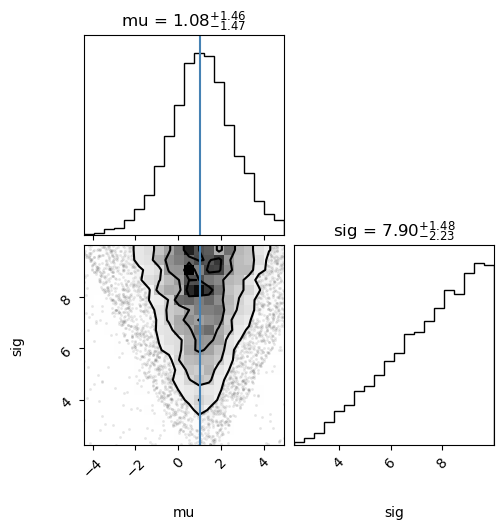

In [9]:
def loglike_unnormalized(params, data):
    mu = params['mu']
    sig = params['sig']

    lls = -(data-mu)**2 / (2*sig**2)

    return np.sum(lls)

sampler = nautilus.Sampler(prior, loglike_unnormalized, likelihood_kwargs={'data': data}, pool=4)
sampler.run(discard_exploration=True, verbose=True)

post, log_w, log_l = sampler.posterior(return_as_dict=True)
w = np.exp(log_w)
corner.corner(np.array([post[pnm] for pnm in prior.keys]).T, weights=w, truths=truths, labels=prior.keys, show_titles=True, range=[.999]*len(prior.keys))

sampler.log_z

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 15     | 1        | 4        | 43400    | N/A    | 10056 | -21.87   


np.float64(-21.87008883754567)

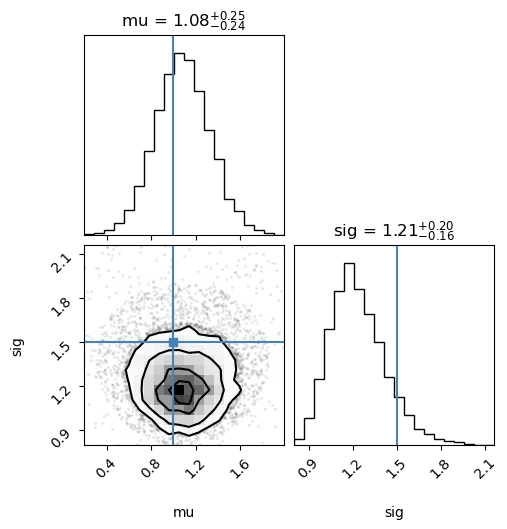

In [10]:
def loglike_normalized_noconstant(params, data):
    mu = params['mu']
    sig = params['sig']

    lls = -(data-mu)**2 / (2*sig**2) - np.log(sig)

    return np.sum(lls)

sampler = nautilus.Sampler(prior, loglike_normalized_noconstant, likelihood_kwargs={'data': data}, pool=4)
sampler.run(discard_exploration=True, verbose=True)

post, log_w, log_l = sampler.posterior(return_as_dict=True)
w = np.exp(log_w)
corner.corner(np.array([post[pnm] for pnm in prior.keys]).T, weights=w, truths=truths, labels=prior.keys, show_titles=True, range=[.999]*len(prior.keys))

sampler.log_z

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 15     | 1        | 4        | 43000    | N/A    | 10031 | -44.84   


np.float64(-44.83556986083637)

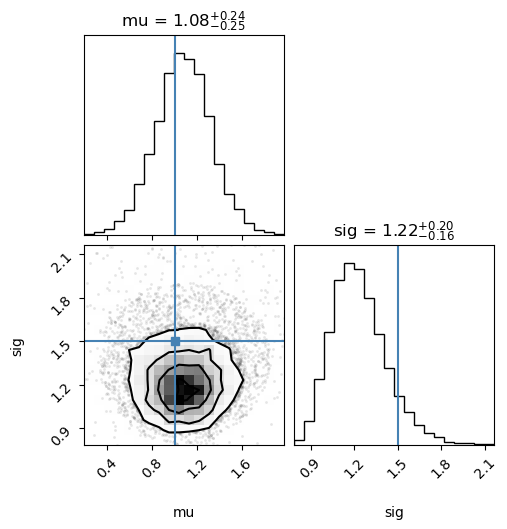

In [11]:
def loglike_normalized(params, data):
    mu = params['mu']
    sig = params['sig']

    lls = -(data-mu)**2 / (2*sig**2) - np.log(sig) - 0.5*np.log(2*np.pi)

    return np.sum(lls)

sampler = nautilus.Sampler(prior, loglike_normalized, likelihood_kwargs={'data': data}, pool=4)
sampler.run(discard_exploration=True, verbose=True)

post, log_w, log_l = sampler.posterior(return_as_dict=True)
w = np.exp(log_w)
corner.corner(np.array([post[pnm] for pnm in prior.keys]).T, weights=w, truths=truths, labels=prior.keys, show_titles=True, range=[.999]*len(prior.keys))

sampler.log_z

Clearly it matters a lot if you have the normalization term in there.  The *shape* doesn't compare about the normalization constant, but the evidence does.

## Scale-free prior

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 15     | 1        | 4        | 42200    | N/A    | 10062 | -44.27   


np.float64(-44.26727078953223)

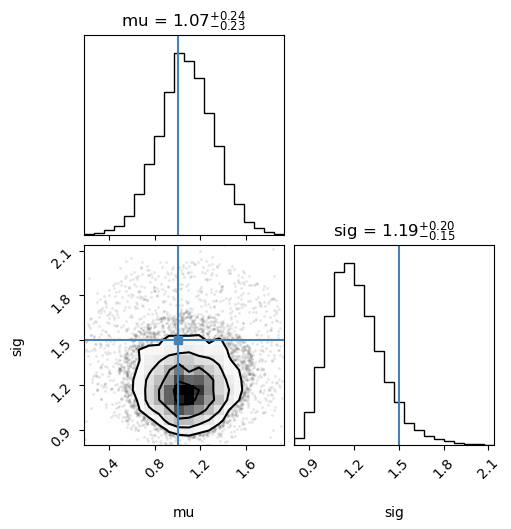

In [13]:
prior2 = nautilus.Prior()
prior2.add_parameter('mu', (-5, 5))
prior2.add_parameter('sig', stats.loguniform(.1, 10))

sampler = nautilus.Sampler(prior2, loglike_normalized, likelihood_kwargs={'data': data}, pool=4)
sampler.run(discard_exploration=True, verbose=True)

post, log_w, log_l = sampler.posterior(return_as_dict=True)
w = np.exp(log_w)
corner.corner(np.array([post[pnm] for pnm in prior2.keys]).T, weights=w, truths=truths, labels=prior2.keys, show_titles=True, range=[.999]*len(prior2.keys))

sampler.log_z

## Different data sizes

In [ ]:
n_datas = np.geomspace(5, 10000, 8).astype(int)

logzs = []
for n_data in n_datas:
    data = np.random.randn(n_data)*truths[1] + truths[0]

    sampler = nautilus.Sampler(prior, loglike_normalized, likelihood_kwargs={'data': data})
    sampler.run(discard_exploration=True, verbose=True)
    post, log_w, log_l = sampler.posterior(return_as_dict=True)
    w = np.exp(log_w)
    corner.corner(np.array([post[pnm] for pnm in prior.keys]).T, weights=w, truths=truths, labels=prior.keys, show_titles=True, range=[.999]*len(prior.keys), pool=4)

    logzs.append(float(sampler.log_z))


plt.figure()
plt.scatter(n_datas, logzs)
plt.xlabel("Number of data points")
plt.ylabel("Log Evidence")

n_datas

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 12     | 1        | 4        | 35600    | N/A    | 10081 | -12.41   
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    


In [ ]:
plt.figure()
plt.scatter(n_datas, np.array(logzs)/n_datas)
plt.xlabel("Number of data points")
plt.ylabel("Log Evidence per data point")

Text(0, 0.5, 'Log Evidence per data point')

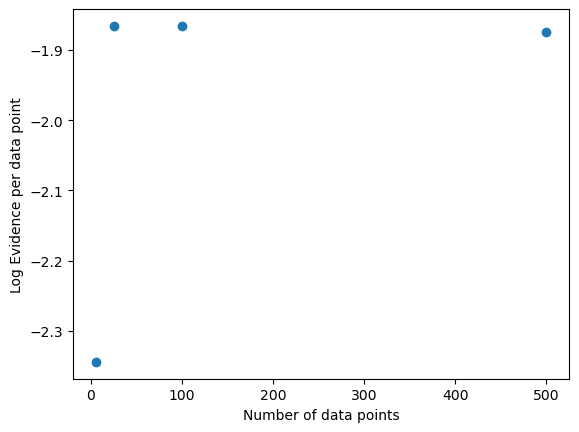